In [6]:
from data import *
import matplotlib.pyplot as plt

In [7]:
path_list = glob('/home/virgile/data/vad_data_augmented/*.wav')

In [8]:
dataset = MelVADDataset(path_list=path_list, n_frames=256)

In [54]:
data['spectro'].shape

torch.Size([1, 64, 256])

tensor([1171]) <class 'torch.Tensor'>


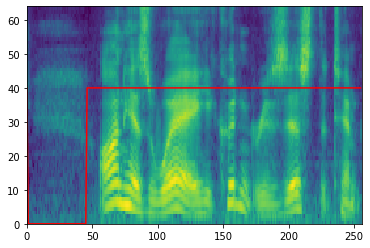

In [53]:
data = dataset[1]
plt.plot(data['targets'].numpy()[0]*40, color='red')
plt.pcolormesh(data['spectro'].numpy()[0])

In [178]:
import torch as th
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, ch_in, ch_out, ks=(3, 3), s=1, p=1):
        super().__init__()
        self.conv = nn.Conv2d(ch_in, ch_out, ks, s, p)
        self.bn = nn.BatchNorm2d(ch_out)
        self.act = nn.PReLU()
        self.mp = nn.MaxPool2d(kernel_size=[2, 1])

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        x = self.mp(x)
        return x


class CNNEmbedder(nn.Module):
    def __init__(self, ch_in, ch_out):
        super().__init__()
        self.convblock1 = ConvBlock(ch_in, ch_out)
        self.convblock2 = ConvBlock(ch_out, ch_out)
        self.convblock3 = ConvBlock(ch_out, ch_out)
        self.convblock4 = ConvBlock(ch_out, ch_out)
    
    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        return x


class VADNet(nn.Module):
    def __init__(self, n_feat=256, cnn_channels=32, embed_dim=256, num_heads=16):
        super().__init__()
        self.cnn_embedder = CNNEmbedder(ch_in=1, ch_out=cnn_channels) 
        self.fc1 = nn.Linear(in_features=512, out_features=embed_dim)
        self.self_attention = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads)
        self.layer_norm1 = nn.LayerNorm(embed_dim)
        self.layer_norm2 = nn.LayerNorm(embed_dim)

        self.mlp = nn.Sequential(
            nn.Linear(in_features=embed_dim, out_features=512),
            nn.Linear(in_features=512, out_features=256)
        )
        self.fc2 = nn.Linear(in_features=256, out_features=1)
        
    def forward(self, x):
        x = self.cnn_embedder(x)
        x = th.flatten(x, start_dim=1, end_dim=2)
        x = x.permute(0, 2, 1)
        x = res = self.fc1(x)
        x, _ = self.self_attention(x, x, x)
        x += res
        x = res = self.layer_norm1(x)
        x = self.mlp(x)
        x += res
        x = self.layer_norm2(x)
        x = self.fc2(x)
        return x

In [179]:
model = VADNet()

In [191]:
x = th.randn((2, 1, 256, 256))

In [192]:
probs = model(x)
probs.shape

torch.Size([2, 256, 1])